### M2 - DistilBERT

This notebook is dedicated for running DistilBERT model as a part of Milestone 2

##### For running in Colab

In [ ]:
!pip install conllu
!pip install transformers-interpret

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# Verify current working directory
print("Current working directory:", os.getcwd())

Current working directory: /content


##### Locally & Colab

In [4]:
# imports
from sklearn.model_selection import train_test_split as split
import torch

#evaluation
from transformers_interpret import SequenceClassificationExplainer
from sklearn.metrics import classification_report

#model
from src.data_util import load_data
from src.dbert import extract_data, encode_data, dataloader, train_bert, plot_metrics, test_bert
from transformers import DistilBertTokenizer
from transformers import AutoModelForSequenceClassification, DistilBertConfig

#plots
import matplotlib.pyplot as plt
import seaborn as sns

#support
from collections import defaultdict

In [5]:
#Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#### Data import

In [6]:
# load the data
path = "../data/dataset.conllu"
headlines = load_data(path)

#train test validation split
SEED = 42
tr_data, other_data = split(headlines, test_size=0.3, random_state=SEED)
val_data, ts_data = split(other_data, test_size=0.5, random_state=SEED)
print(f"Number of headlines for training, validation, and test is {len(tr_data)}, {len(val_data)}, and {len(ts_data)} resp.")

Number of headlines for training, validation, and test is 20033, 4293, and 4293 resp.


In [7]:
#Get texts and labels from the data
tr_texts, tr_labels = extract_data(tr_data)
val_texts, val_labels = extract_data(val_data)
ts_texts, ts_labels = extract_data(ts_data)

#### Data prep

In [8]:
# Initialize the BERT tokenizer
pretrained_model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [9]:
# Tokenize data
tr_tokens, tr_atention = encode_data(tr_texts, tokenizer)
val_tokens, val_atention = encode_data(val_texts, tokenizer)
ts_tokens, ts_atention = encode_data(ts_texts, tokenizer)

In [10]:
# Prepaire data for the model
train = dataloader(tr_tokens, tr_atention, tr_labels, tr_texts, batch_size=8, isTrain = True)
validation = dataloader(val_tokens, val_atention, val_labels, val_texts, batch_size=8)
test = dataloader(ts_tokens, ts_atention, ts_labels, ts_texts, batch_size=8)

#### Model setup

In [11]:
# Load the DistilBERT model's configuration
config = DistilBertConfig.from_pretrained('distilbert-base-uncased')

# Labels
id2label = {0: "not_sarcastic", 1: "sarcastic"}
label2id = {"not_sarcastic": 0, "sarcastic": 1}

# Modify the dropout rates (increase them as needed)
config.attention_probs_dropout_prob = 0.25  # Default is 0.1
config.hidden_dropout_prob = 0.25  # Default is 0.1
config.num_labels = 2
config.id2label = id2label
config.label2id = label2id


model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    config=config
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Train DistilBERT Model

In [12]:
# We only want to finetune the classification layer on top of BERT
for p in model.base_model.parameters():
    p.requires_grad = False


for p in model.classifier.parameters():
    print(p.requires_grad)  # Check trainable status

True
True


In [13]:
from tqdm import tqdm  # Standard tqdm for scripts
from tqdm.notebook import tqdm as notebook_tqdm

best_acc, val_loss, train_loss, val_acc, train_acc = train_bert(
    model=model,
    trainloader=train,
    validationloader=validation,
    device=device,
    epochs=10,
    patience=5
)
print(f"Best Validation Accuracy: {best_acc:.4f}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting training for 10 epochs with early stopping (patience=5).

Epoch 1/10


Training: 100%|██████████| 2504/2504 [00:36<00:00, 68.00batch/s, loss=0.657]


Total loss: 1467.3346, Training Loss: 0.0732, Training Accuracy: 0.6998


Validation: 100%|██████████| 536/536 [00:03<00:00, 134.42batch/s]


Validation Loss: 0.0587, Validation Accuracy: 0.7901
Validation accuracy improved. Best model updated.

Epoch 2/10


Training: 100%|██████████| 2504/2504 [00:34<00:00, 73.01batch/s, loss=0.624]


Total loss: 1122.1201, Training Loss: 0.0560, Training Accuracy: 0.7957


Validation: 100%|██████████| 536/536 [00:06<00:00, 80.07batch/s] 


Validation Loss: 0.0510, Validation Accuracy: 0.8190
Validation accuracy improved. Best model updated.

Epoch 3/10


Training: 100%|██████████| 2504/2504 [00:34<00:00, 72.25batch/s, loss=0.563]


Total loss: 1041.6463, Training Loss: 0.0520, Training Accuracy: 0.8122


Validation: 100%|██████████| 536/536 [00:03<00:00, 134.56batch/s]


Validation Loss: 0.0484, Validation Accuracy: 0.8267
Validation accuracy improved. Best model updated.

Epoch 4/10


Training: 100%|██████████| 2504/2504 [00:34<00:00, 72.24batch/s, loss=0.53]


Total loss: 1003.5599, Training Loss: 0.0501, Training Accuracy: 0.8171


Validation: 100%|██████████| 536/536 [00:05<00:00, 105.22batch/s]


Validation Loss: 0.0471, Validation Accuracy: 0.8334
Validation accuracy improved. Best model updated.

Epoch 5/10


Training: 100%|██████████| 2504/2504 [00:34<00:00, 71.94batch/s, loss=0.612]


Total loss: 975.4217, Training Loss: 0.0487, Training Accuracy: 0.8244


Validation: 100%|██████████| 536/536 [00:04<00:00, 133.08batch/s]


Validation Loss: 0.0462, Validation Accuracy: 0.8355
Validation accuracy improved. Best model updated.

Epoch 6/10


Training: 100%|██████████| 2504/2504 [00:38<00:00, 65.03batch/s, loss=0.669]


Total loss: 956.2306, Training Loss: 0.0477, Training Accuracy: 0.8273


Validation: 100%|██████████| 536/536 [00:04<00:00, 128.31batch/s]


Validation Loss: 0.0457, Validation Accuracy: 0.8400
Validation accuracy improved. Best model updated.

Epoch 7/10


Training: 100%|██████████| 2504/2504 [00:37<00:00, 66.41batch/s, loss=0.549]


Total loss: 942.2626, Training Loss: 0.0470, Training Accuracy: 0.8324


Validation: 100%|██████████| 536/536 [00:05<00:00, 99.87batch/s] 


Validation Loss: 0.0452, Validation Accuracy: 0.8428
Validation accuracy improved. Best model updated.

Epoch 8/10


Training: 100%|██████████| 2504/2504 [00:37<00:00, 67.06batch/s, loss=0.571]


Total loss: 934.0833, Training Loss: 0.0466, Training Accuracy: 0.8312


Validation: 100%|██████████| 536/536 [00:04<00:00, 127.02batch/s]


Validation Loss: 0.0449, Validation Accuracy: 0.8437
Validation accuracy improved. Best model updated.

Epoch 9/10


Training: 100%|██████████| 2504/2504 [00:38<00:00, 65.60batch/s, loss=0.659]


Total loss: 931.8197, Training Loss: 0.0465, Training Accuracy: 0.8338


Validation: 100%|██████████| 536/536 [00:04<00:00, 130.04batch/s]


Validation Loss: 0.0448, Validation Accuracy: 0.8423
No improvement in validation for 1 consecutive epoch(s).

Epoch 10/10


Training: 100%|██████████| 2504/2504 [00:37<00:00, 66.98batch/s, loss=0.417]


Total loss: 927.7403, Training Loss: 0.0463, Training Accuracy: 0.8317


Validation: 100%|██████████| 536/536 [00:05<00:00, 99.01batch/s] 

Validation Loss: 0.0449, Validation Accuracy: 0.8390
No improvement in validation for 2 consecutive epoch(s).
Training completed.
Best Validation Accuracy: 0.8437


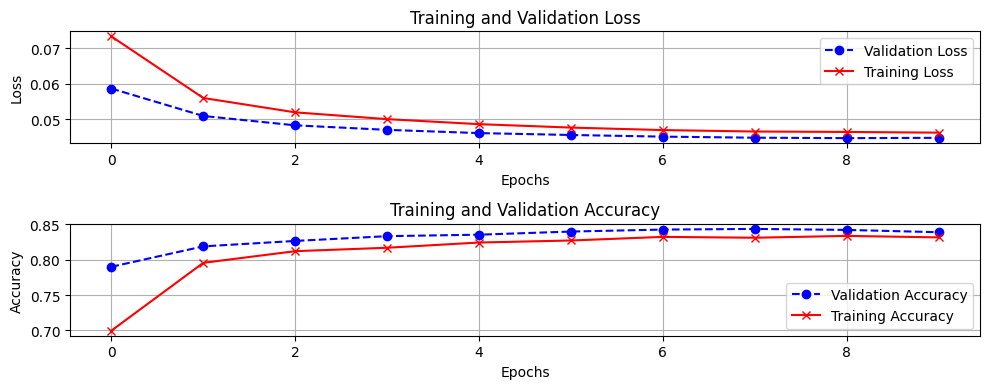

In [14]:
# Train vs validation metrics
plot_metrics(val_loss, train_loss, val_acc, train_acc)

#### Misclass analysis - quantitative

In [15]:
model.load_state_dict(torch.load("/content/best_model.pth"))
model.to(device)
test_metrics = test_bert(model, test, device)

<ipython-input-15-3ef9401ae220>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_model.pth"))
Testing: 100%|██████████| 536/5


Test Metrics:
Loss: 0.0449
Accuracy: 0.8377
Precision: 0.8300
Recall: 0.8316
F1-Score: 0.8308
ROC-AUC: 0.9203
MCC: 0.6748
Confusion Matrix:
[[1883  350]
 [ 346 1709]]


In [26]:
#Store predictions on the test set & misclass cases into df
df = test_metrics["df"]

mismatched_df = df[df['True Label'] != df['Predicted Label']]
mismatched_df

,True Label,Predicted Label,Probability,Sentences
1,1,0.0,0.312223,study owning a boat not worth it
12,1,0.0,0.352375,gay conversion therapists claim most patients ...
26,0,1.0,0.767053,white terror demands white action what allies ...
31,0,1.0,0.692379,surge soda is back
33,1,0.0,0.280620,supreme court upholds bill of rights in 54 dec...
...,...,...,...,...
4251,1,0.0,0.431628,delirious rover hallucinates water on mars
4255,1,0.0,0.251955,israeli soldiers open fire on palestinians car...
4260,0,1.0,0.669917,radio host pranks the out of cohost
4267,1,0.0,0.049339,mom wants to know if the people who live in yo...


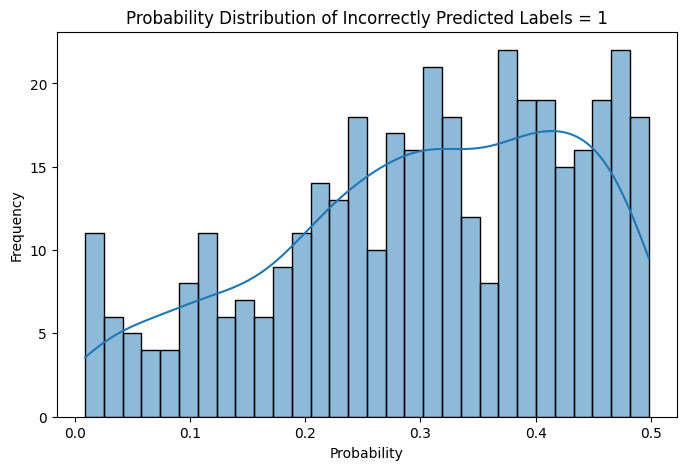

In [15]:
# Create the probability distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(mismatched_df[mismatched_df['True Label']== 1.0]['Probability'], bins = 30, kde=True)
plt.title('Probability Distribution of Incorrectly Predicted Labels = 1')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

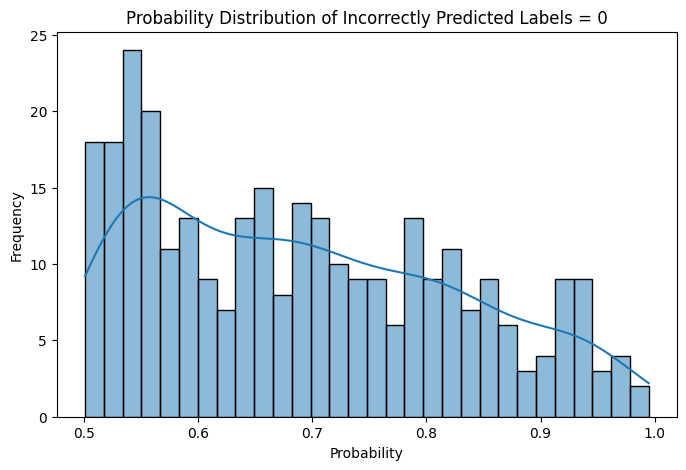

In [16]:
# Create the probability distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(mismatched_df[mismatched_df['True Label']== 0]['Probability'], bins = 30, kde=True)
plt.title('Probability Distribution of Incorrectly Predicted Labels = 0')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

Model is not confident near the borders

In [17]:
target_names = target_names = ['Not Sarcastic', 'Sarcastic']
print(classification_report(df["True Label"], df["Predicted Label"], target_names = target_names))

               precision    recall  f1-score   support

Not Sarcastic       0.83      0.86      0.85      2233
    Sarcastic       0.85      0.81      0.83      2055

     accuracy                           0.84      4288
    macro avg       0.84      0.84      0.84      4288
 weighted avg       0.84      0.84      0.84      4288



#### Misclass - tokens

In [17]:
binary_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)

In [28]:
misclass_sentences = list(mismatched_df[mismatched_df["True Label"] == 1]["Sentences"])
predicted_labels = list(mismatched_df[mismatched_df["True Label"] == 1]["Predicted Label"])

In [37]:
def interpret_sentence(sentence):
  word_attributions = binary_explainer(sentence)
  print(word_attributions)
  print("Predicted class:", binary_explainer.predicted_class_name)
  return binary_explainer.visualize()

#misclass_sentences = list(mismatched_df["Sentences"])
#predicted_labels = list(mismatched_df["Predicted Label"])

for sentence in range(20):
    print(f"Sentence: {misclass_sentences[sentence]}")
    #print(f"Predicted Label: {predicted_labels[sentence]}")
    interpret_sentence(misclass_sentences[sentence])

Sentence: study owning a boat not worth it
[('[CLS]', 0.0), ('study', 0.13295892144384538), ('owning', -0.2698667365447461), ('a', 0.8767476643931603), ('boat', -0.1723044721227208), ('not', -0.020581121606281137), ('worth', 0.3096450511081059), ('it', -0.12171660256724548), ('[SEP]', 0.0)]
Predicted class: not_sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.61),not_sarcastic,0.73,[CLS] study owning a boat not worth it [SEP]


Sentence: gay conversion therapists claim most patients fully straight by the time they commit suicide
[('[CLS]', 0.0), ('gay', 0.20993222605589215), ('conversion', -0.009929447037790555), ('therapist', -0.15370523063514435), ('##s', 0.685309723681947), ('claim', 0.3032000222930343), ('most', 0.0430600964240098), ('patients', -0.10032413416385222), ('fully', -0.11313800892637728), ('straight', 0.07526644387349687), ('by', 0.3061586361493621), ('the', 0.4239511080355989), ('time', 0.00458181636892337), ('they', 0.2392989972524394), ('commit', 0.08942654138088485), ('suicide', 0.03861068980992865), ('[SEP]', 0.0)]
Predicted class: not_sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.64),not_sarcastic,2.04,[CLS] gay conversion therapist ##s claim most patients fully straight by the time they commit suicide [SEP]


Sentence: supreme court upholds bill of rights in 54 decision
[('[CLS]', 0.0), ('supreme', -0.12437181890728233), ('court', -0.05946603681738112), ('uphold', 0.044884621256459936), ('##s', 0.610508300844108), ('bill', -0.11833144252065272), ('of', -0.10485868968148841), ('rights', 0.260484754873899), ('in', 0.6184867277563537), ('54', -0.04340133525505731), ('decision', 0.35916700234973725), ('[SEP]', 0.0)]
Predicted class: not_sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.66),not_sarcastic,1.44,[CLS] supreme court uphold ##s bill of rights in 54 decision [SEP]


Sentence: exxonmobil swears its going to start taxes early this year
[('[CLS]', 0.0), ('ex', -0.07624488232790047), ('##xon', -0.14219227661206332), ('##mo', -0.6100533259694392), ('##bil', 0.04337363432671693), ('swear', 0.10025074032121997), ('##s', -0.19822601472712062), ('its', -0.17018445822680692), ('going', -0.058983536505890624), ('to', -0.10886446628552314), ('start', 0.27100242325093615), ('taxes', -0.3584976678457033), ('early', 0.3782514032435129), ('this', -0.3578017754467068), ('year', 0.18227883204732237), ('[SEP]', 0.0)]
Predicted class: sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.59),sarcastic,-1.11,[CLS] ex ##xon ##mo ##bil swear ##s its going to start taxes early this year [SEP]


Sentence: biden calls dibs on qaddafis clothes
[('[CLS]', 0.0), ('bid', -0.02879450346815127), ('##en', 0.063746772453823), ('calls', -0.18901393315727905), ('di', -0.19751226297060015), ('##bs', 0.4135731958356066), ('on', 0.6576513582746454), ('q', 0.3737522399655815), ('##ad', 0.11162478108137736), ('##da', 0.04007299755502442), ('##fi', 0.1297247745541804), ('##s', 0.19098776361662584), ('clothes', -0.33130084593615966), ('[SEP]', 0.0)]
Predicted class: not_sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.66),not_sarcastic,1.23,[CLS] bid ##en calls di ##bs on q ##ad ##da ##fi ##s clothes [SEP]


Sentence: fat kid just wants to watch you guys play
[('[CLS]', 0.0), ('fat', 0.15716662366644948), ('kid', 0.12561606979515996), ('just', -0.8271479406834943), ('wants', 0.023335049655701098), ('to', -0.1901554292085591), ('watch', 0.038169374238370496), ('you', -0.45647227690808395), ('guys', 0.09227525598721997), ('play', -0.14248987421823728), ('[SEP]', 0.0)]
Predicted class: sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.59),sarcastic,-1.18,[CLS] fat kid just wants to watch you guys play [SEP]


Sentence: mayor daleys son appointed head of illinois nepotist party
[('[CLS]', 0.0), ('mayor', -0.04121171421165861), ('dale', -0.06326845476999468), ('##ys', 0.5392192117075134), ('son', 0.2580885243013052), ('appointed', -0.4953605821763916), ('head', 0.06472174530960097), ('of', -0.022108189592199484), ('illinois', 0.0946358676135514), ('ne', -0.04433068637427958), ('##pot', 0.42577785849813166), ('##ist', 0.3642206260271223), ('party', 0.24901257689307368), ('[SEP]', 0.0)]
Predicted class: not_sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.53),not_sarcastic,1.33,[CLS] mayor dale ##ys son appointed head of illinois ne ##pot ##ist party [SEP]


Sentence: supporters praise trump for upholding traditional american value of supporting murderous dictators for political gain
[('[CLS]', 0.0), ('supporters', 0.013789636208084854), ('praise', -0.13889810874347616), ('trump', 0.6166539986688637), ('for', 0.6492855827070994), ('uphold', 0.07362248206200747), ('##ing', -0.03922559578903827), ('traditional', 0.13605866144280943), ('american', -0.005070872430604492), ('value', 0.003147163699139122), ('of', -0.0013919822571685162), ('supporting', -0.1020796048068752), ('murderous', -0.12575467748222366), ('dictator', 0.03944011680501972), ('##s', 0.2035501690681208), ('for', 0.2563716888588693), ('political', 0.12690381939965018), ('gain', 0.046055463914545035), ('[SEP]', 0.0)]
Predicted class: not_sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.80),not_sarcastic,1.75,[CLS] supporters praise trump for uphold ##ing traditional american value of supporting murderous dictator ##s for political gain [SEP]


Sentence: kirstjen nielsen urges migrant parents leave the weak ones behind
[('[CLS]', 0.0), ('ki', 0.13158499160659465), ('##rst', 0.25597216134331136), ('##je', 0.331999793471437), ('##n', 0.5245131631740394), ('nielsen', 0.1131472974678336), ('urges', -0.17196236985098207), ('migrant', 0.2921159158752522), ('parents', -0.24376877875783518), ('leave', -0.1261866493885339), ('the', 0.36218822444003385), ('weak', 0.0411678313597246), ('ones', 0.4425994050434712), ('behind', 0.0022414122383537715), ('[SEP]', 0.0)]
Predicted class: not_sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.73),not_sarcastic,1.96,[CLS] ki ##rst ##je ##n nielsen urges migrant parents leave the weak ones behind [SEP]


Sentence: cory booker tries to relate to rural voters by mangling hand in grain auger
[('[CLS]', 0.0), ('cory', -0.10695297258208056), ('booker', -0.45266114039711053), ('tries', -0.22257489709719505), ('to', -0.15178355886136036), ('relate', -0.663661265519259), ('to', -0.08275321111996072), ('rural', 0.12755605366419084), ('voters', -0.06827648807299225), ('by', -0.24514179643563908), ('man', -0.05614194678044557), ('##gling', -0.16641189459403655), ('hand', 0.0036523735900615734), ('in', 0.11098840270613972), ('grain', 0.29168796985977413), ('aug', -0.050167466614565046), ('##er', 0.22800170191170865), ('[SEP]', 0.0)]
Predicted class: sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.58),sarcastic,-1.50,[CLS] cory booker tries to relate to rural voters by man ##gling hand in grain aug ##er [SEP]


Sentence: outgoing hhs secretary tommy thompson caught with briefcase full of flu vaccine
[('[CLS]', 0.0), ('outgoing', -0.5847894460584288), ('h', -0.3410391879718959), ('##hs', -0.3390548528655459), ('secretary', -0.28416705071758214), ('tommy', 0.2688982241098307), ('thompson', -0.024504803859455488), ('caught', -0.02639094937105659), ('with', -0.4059082629209382), ('briefcase', 0.26936590488201456), ('full', 0.15347452136705067), ('of', -0.0027982730737583436), ('flu', 0.02871587413772095), ('vaccine', 0.10341604537831246), ('[SEP]', 0.0)]
Predicted class: sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.54),sarcastic,-1.18,[CLS] outgoing h ##hs secretary tommy thompson caught with briefcase full of flu vaccine [SEP]


Sentence: maybe hang out in the water awhile then look for some old bread duck tells self
[('[CLS]', 0.0), ('maybe', 0.00041514739291846994), ('hang', -0.045845884876696844), ('out', 0.07308774338805032), ('in', -0.19424490634728483), ('the', -0.21616781899967624), ('water', 0.0684492435199489), ('awhile', 0.2789243162381792), ('then', -0.16241604939472024), ('look', 0.001431879869153079), ('for', -0.2944523647674273), ('some', -0.13867268683651085), ('old', 0.3371142840977903), ('bread', 0.13979006179508932), ('duck', -0.05318459908573529), ('tells', 0.5928620617811469), ('self', 0.45364944742317015), ('[SEP]', 0.0)]
Predicted class: sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.90),sarcastic,0.84,[CLS] maybe hang out in the water awhile then look for some old bread duck tells self [SEP]


Sentence: philip morris lawyers deny cigarettes are cylindrical
[('[CLS]', 0.0), ('philip', -0.11857364233194662), ('morris', 0.22190180076099975), ('lawyers', 0.23950533807016), ('deny', -0.0008283896647730189), ('cigarettes', 0.043888412631454765), ('are', 0.8063887793204457), ('cylindrical', -0.47659976163694795), ('[SEP]', 0.0)]
Predicted class: not_sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.62),not_sarcastic,0.72,[CLS] philip morris lawyers deny cigarettes are cylindrical [SEP]


Sentence: cat speeddials exgirlfriend
[('[CLS]', 0.0), ('cat', 0.2211334623700854), ('speed', 0.27392342369668565), ('##dial', -0.17221830907206964), ('##s', -0.761611755348728), ('ex', -0.08222968661294996), ('##girl', -0.3899539582300617), ('##fr', -0.05906237734346397), ('##ien', -0.01838163116055432), ('##d', 0.3220283810848808), ('[SEP]', 0.0)]
Predicted class: sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.53),sarcastic,-0.67,[CLS] cat speed ##dial ##s ex ##girl ##fr ##ien ##d [SEP]


Sentence: rwandan refugees angered over lack of aol access
[('[CLS]', 0.0), ('rwanda', 0.12461742517118632), ('##n', 0.4551374654202506), ('refugees', 0.22183876380655274), ('angered', -0.37848530999637015), ('over', 0.15688436084272703), ('lack', -0.001305080090092852), ('of', -0.22897451824446263), ('ao', 0.24745920072075317), ('##l', 0.47784540435020467), ('access', 0.46716249368709506), ('[SEP]', 0.0)]
Predicted class: not_sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.62),not_sarcastic,1.54,[CLS] rwanda ##n refugees angered over lack of ao ##l access [SEP]


Sentence: israel builds new settlement to host palestinian peace talks
[('[CLS]', 0.0), ('israel', 0.3949538072388489), ('builds', 0.38901830039831203), ('new', 0.25997218754654405), ('settlement', -0.13784555396767), ('to', 0.1108349368843086), ('host', 0.13928889030375832), ('palestinian', 0.5645015408406268), ('peace', 0.4798664631935938), ('talks', 0.15959237685674696), ('[SEP]', 0.0)]
Predicted class: not_sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.63),not_sarcastic,2.36,[CLS] israel builds new settlement to host palestinian peace talks [SEP]


Sentence: update the onion apologizes for killing innocent boston man tom mahoney
[('[CLS]', 0.0), ('update', -0.014174268789739625), ('the', 0.34906239837542524), ('onion', 0.3234505400233736), ('apologize', -0.3796198590469399), ('##s', 0.4383362849835294), ('for', 0.3557831358169706), ('killing', -0.20691336842308428), ('innocent', -0.05304126232126396), ('boston', 0.08682369355146861), ('man', 0.009077864241878257), ('tom', -0.17878224032485976), ('ma', 0.06872221142841425), ('##hone', 0.15170666290371113), ('##y', 0.44447123885018897), ('[SEP]', 0.0)]
Predicted class: not_sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.73),not_sarcastic,1.39,[CLS] update the onion apologize ##s for killing innocent boston man tom ma ##hone ##y [SEP]


Sentence: pope francis worried about job security after butting heads with new god
[('[CLS]', 0.0), ('pope', 0.8142166536835742), ('francis', 0.054338599720086686), ('worried', -0.03197325210087404), ('about', 0.2998832231854839), ('job', 0.25657422997299717), ('security', 0.03917009842164641), ('after', 0.2805937264431842), ('butt', 0.0053187810343658685), ('##ing', 0.10615565651660969), ('heads', 0.004869146286028632), ('with', 0.2219262423519393), ('new', -0.12213067933030608), ('god', -0.14683551452233595), ('[SEP]', 0.0)]
Predicted class: not_sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.59),not_sarcastic,1.78,[CLS] pope francis worried about job security after butt ##ing heads with new god [SEP]


Sentence: chuck grassley voted against mlk day due to foreseeing how everyone would dishonor kings memory
[('[CLS]', 0.0), ('chuck', -0.18588077081185578), ('grass', 0.3243707917159942), ('##ley', 0.05884304582461106), ('voted', 0.2265866851318505), ('against', 0.5918926073458037), ('ml', 0.15769802954155718), ('##k', 0.223406034252872), ('day', 0.14658580782087868), ('due', 0.17498544759958948), ('to', 0.04908855993518507), ('fore', 0.06279697429298775), ('##see', 0.033660870047409336), ('##ing', -0.029384306389422733), ('how', 0.35003322457108854), ('everyone', 0.16013608182698502), ('would', -0.09055258314486092), ('dish', 0.1645594711879211), ('##ono', 0.21257078139116753), ('##r', 0.11928008851560164), ('kings', 0.19191465504045), ('memory', -0.20040820027613573), ('[SEP]', 0.0)]
Predicted class: not_sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,not_sarcastic (0.67),not_sarcastic,2.74,[CLS] chuck grass ##ley voted against ml ##k day due to fore ##see ##ing how everyone would dish ##ono ##r kings memory [SEP]


Sentence: stanford students admit it was pretty obvious billionaires dog didnt get in by itself
[('[CLS]', 0.0), ('stanford', -0.16282154291551093), ('students', -0.1315017855898706), ('admit', -0.454813732359949), ('it', -0.30574024796024213), ('was', 0.2086598242841722), ('pretty', -0.00908682968252633), ('obvious', 0.030117872592125394), ('billionaire', 0.01213367728088681), ('##s', -0.3493872009729519), ('dog', 0.08380245864637079), ('didn', 0.5656762601043509), ('##t', -0.196744154383467), ('get', 0.15683005868547148), ('in', 0.14853194357679428), ('by', -0.2768559664996358), ('itself', 0.009444389893489951), ('[SEP]', 0.0)]
Predicted class: sarcastic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,sarcastic (0.66),sarcastic,-0.67,[CLS] stanford students admit it was pretty obvious billionaire ##s dog didn ##t get in by itself [SEP]


In [30]:
# Initialize dictionaries to store positive and negative counts for each token
positive_token_counts = defaultdict(int)
negative_token_counts = defaultdict(int)

# Define a function to interpret a sentence and aggregate scores
def interpret_sentence_and_aggregate(sentence ):
    word_attributions = binary_explainer(sentence)

    # Extract tokens and scores from word_attributions
    for token, score in word_attributions:  # Assuming word_attributions is a list of (token, score)
        if score > 0:
            positive_token_counts[token] += 1
        elif score < 0:
            negative_token_counts[token] += 1

# Iterate over sentences
#misclass_sentences = list(mismatched_df["Sentences"])
#predicted_labels = list(mismatched_df["Predicted Label"])

for sentence in misclass_sentences:
    interpret_sentence_and_aggregate(sentence)

In [33]:
# Calculate total counts for positive and negative tokens
total_positive_tokens = sum(positive_token_counts.values())
total_negative_tokens = sum(negative_token_counts.values())


#(count / total_positive_tokens) * 100
# Calculate percentage contributions
positive_token_percentages = {
    token: (count / total_positive_tokens) * 100  for token, count in positive_token_counts.items()
}
negative_token_percentages = {
    token: (count / total_positive_tokens) * 100  for token, count in negative_token_counts.items()
}


# Sort and get top 10 tokens for positive and negative percentages
top_positive_tokens = sorted(positive_token_percentages.items(), key=lambda x: x[1], reverse=True)[:20]
top_negative_tokens = sorted(negative_token_percentages.items(), key=lambda x: x[1], reverse=True)[:20]

# Print the top 10 results with percentages
print("Top 10 tokens more often positive (as percentage of total):")
for token, percentage in top_positive_tokens:
    print(f"{token}: {percentage:.2f}%")

print("\nTop 10 tokens more often negative (as percentage of total):")
for token, percentage in top_negative_tokens:
    print(f"{token}: {percentage:.2f}%")


Top 10 tokens more often positive (as percentage of total):
to: 2.67%
##s: 2.63%
of: 2.43%
the: 1.53%
in: 1.41%
for: 1.33%
on: 0.94%
you: 0.75%
a: 0.71%
trump: 0.63%
your: 0.63%
by: 0.59%
from: 0.59%
new: 0.47%
and: 0.43%
about: 0.39%
after: 0.39%
it: 0.39%
with: 0.35%
at: 0.35%

Top 10 tokens more often negative (as percentage of total):
to: 1.69%
of: 1.30%
##s: 1.30%
in: 0.67%
new: 0.43%
for: 0.39%
on: 0.35%
by: 0.31%
you: 0.27%
into: 0.27%
trump: 0.27%
after: 0.27%
at: 0.27%
be: 0.27%
the: 0.24%
a: 0.24%
us: 0.24%
it: 0.20%
man: 0.20%
woman: 0.20%
